In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mohirdev/train_data.csv
/kaggle/input/mohirdev/test_data.csv
/kaggle/input/mohirdev/sample_solution.csv


Notebook for the competition: https://www.kaggle.com/competitions/aviachipta-narxini-bashorat-qilish

In [2]:
df = pd.read_csv('../input/mohirdev/train_data.csv')
df.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


# Exploring data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


> Apparently, there is no missing values.

# Checking for duplicates

In [4]:
df.duplicated().sum()

0

> There is no exact duplicates.

In [5]:
# Checking for duplicates with same parametres but different ticket price
subset = [
    'airline', 
    'flight', 
    'source_city', 
    'departure_time', 
    'stops', 
    'arrival_time', 
    'destination_city', 
    'class', 
    'duration', 
    'days_left'
]

df.duplicated(subset=subset).sum()

10

In [6]:
# Getting rid of incorrect rows
df.drop_duplicates(subset=subset, inplace=True)

Checking for incorrect records that have the same source and destination city

In [7]:
(df['source_city'] == df['destination_city']).sum()

0

> There is no this kind of records.

# Visualizing categorical columns

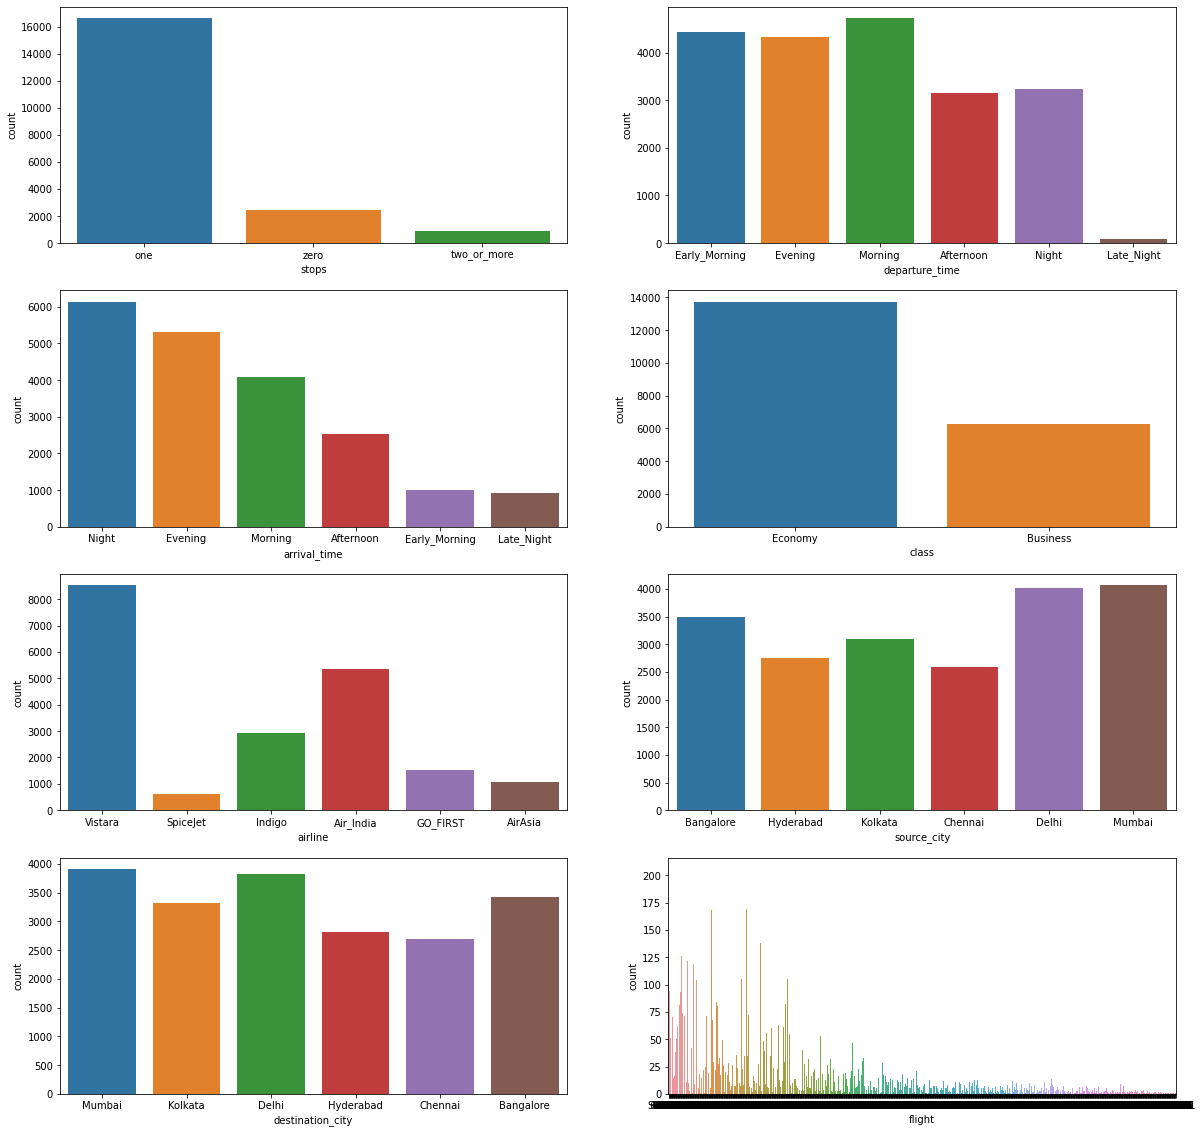

In [8]:
plt.figure(figsize=(20,20))

plt.subplot(4,2,1)
sns.countplot(x=df['stops'])

plt.subplot(4,2,2)
sns.countplot(x=df['departure_time'])

plt.subplot(4,2,3)
sns.countplot(x=df['arrival_time'])

plt.subplot(4,2,4)
sns.countplot(x=df['class'])

plt.subplot(4,2,5)
sns.countplot(x=df['airline'])

plt.subplot(4,2,6)
sns.countplot(x=df['source_city'])

plt.subplot(4,2,7)
sns.countplot(x=df['destination_city'])

plt.subplot(4,2,8)
sns.countplot(x=df['flight'])
plt.show()

> It can be concluded from the chart that some of the columns are categorical ordinal (e.g. Early Morning, Moring, ..., Late Night), so I am going to encode them manually. The other columns are categorical nominal (airline and city names), so I decided to encode them randomly.

Checking numerical columns for outliers

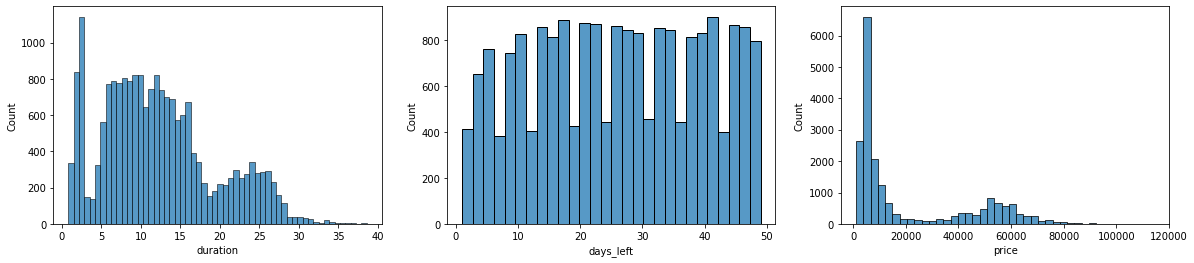

In [9]:
plt.figure(figsize=(20, 4))

plt.subplot(1,3,1)
sns.histplot(df['duration'])

plt.subplot(1,3,2)
sns.histplot(df['days_left'])

plt.subplot(1,3,3)
sns.histplot(df['price'])
plt.show()

In [10]:
df[df['price'] > 80000]

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
236,237,Vistara,UK-996,Mumbai,Evening,one,Morning,Bangalore,Business,16.33,41,85744
586,587,Vistara,UK-836,Chennai,Morning,one,Night,Mumbai,Business,9.50,9,80566
658,659,Vistara,UK-996,Mumbai,Evening,one,Evening,Bangalore,Business,22.50,2,114523
1064,1065,Vistara,UK-810,Bangalore,Early_Morning,one,Afternoon,Mumbai,Business,7.00,10,81788
1165,1166,Vistara,UK-772,Kolkata,Morning,one,Evening,Delhi,Business,9.33,5,83647
...,...,...,...,...,...,...,...,...,...,...,...,...
19197,19198,Vistara,UK-834,Chennai,Evening,one,Morning,Hyderabad,Business,16.50,3,84497
19364,19365,Vistara,UK-985,Delhi,Evening,one,Evening,Kolkata,Business,21.08,1,90057
19491,19492,Vistara,UK-880,Hyderabad,Afternoon,one,Night,Chennai,Business,9.67,44,84075
19501,19502,Vistara,UK-944,Mumbai,Afternoon,one,Night,Bangalore,Business,8.67,17,92772


In [11]:
df[df['price'] > 80000]['class'].value_counts()

Business    136
Name: class, dtype: int64

> There is no outliers.

# Preparing to machine learning

In [12]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_set.drop(columns=["price"])
y = train_set["price"].copy()

In [13]:
# Defining custom encoder
class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col_name, mapper):
        self.col_name = col_name
        self.mapper = mapper
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.col_name] = X[self.col_name].map(self.mapper)
        return X

In [14]:
# Encoding

stops_mapper = {'zero': 0, 'one': 1, 'two_or_more': 2}
times_mapper = {'Early_Morning': 5, 'Morning': 4, 'Afternoon': 3, 'Evening': 2, 'Night': 1, 'Late_Night': 0}
class_mapper = {'Economy': 0, 'Business': 1}

custom_enc_pipeline = Pipeline([
  ('stops_enc', CustomEncoder('stops', stops_mapper)),
  ('departure_time_enc', CustomEncoder('departure_time', times_mapper)),
  ('arrival_time_enc', CustomEncoder('arrival_time', times_mapper)),
  ('class_enc', CustomEncoder('class', class_mapper)),
])


custom_enc_columns = ['stops', 'departure_time', 'arrival_time', 'class', 'duration', 'days_left']
builtin_enc_columns = ['airline', 'source_city', 'destination_city']

full_pipeline = ColumnTransformer([
    ('one', custom_enc_pipeline, custom_enc_columns),
    ('two', OrdinalEncoder(), builtin_enc_columns),
])

X_encoded = full_pipeline.fit_transform(X_train)

In [15]:
# Scaling

X_scaled = MinMaxScaler().fit_transform(X_encoded)

Preparing test set

In [16]:
X_test = test_set.drop(columns=["price"])
y_test = test_set["price"].copy()

X_test_encoded = full_pipeline.fit_transform(X_test)
X_test_scaled = MinMaxScaler().fit_transform(X_test_encoded)

# Training

Linear Regression

In [17]:
LR_model = LinearRegression()
LR_model.fit(X_scaled, y)
y_predicted = LR_model.predict(X_test_scaled)

In [18]:
# Evaluating the model
lin_mse = mean_squared_error(y_test, y_predicted)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6733.216845793656

Decision Tree

In [19]:
DT_model = DecisionTreeRegressor()
DT_model.fit(X_scaled, y)
y_predicted = DT_model.predict(X_test_scaled)

In [20]:
# Evaluating the model
dt_mse = mean_squared_error(y_test, y_predicted)
dt_rmse = np.sqrt(dt_mse)
dt_rmse

5346.231488447169

Random Forest

In [21]:
RF_model = RandomForestRegressor()
RF_model.fit(X_scaled, y)
y_predicted = RF_model.predict(X_test_scaled)

In [22]:
# Evaluating the model
rf_mse = mean_squared_error(y_test, y_predicted)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

4005.518712727501

# Evaluating with cross-validation

In [23]:
X_cv_scaled = MinMaxScaler().fit_transform(full_pipeline.fit_transform(df.drop(columns=["price"])))

In [24]:
# Linear Regression
scores = cross_val_score(LR_model, X_cv_scaled, df['price'].copy(), scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-scores)
LR_rmse_scores.mean()

6903.283317355681

In [25]:
# Decision Tree
scores = cross_val_score(DT_model, X_cv_scaled, df['price'].copy(), scoring="neg_mean_squared_error", cv=10)
DT_rmse_scores = np.sqrt(-scores)
DT_rmse_scores.mean()

5039.967159312206

In [26]:
# Random Forest
scores = cross_val_score(RF_model, X_cv_scaled, df['price'].copy(), scoring="neg_mean_squared_error", cv=10)
RF_rmse_scores = np.sqrt(-scores)
RF_rmse_scores.mean()

3819.872604504996

# Submission

In [27]:
submission = pd.read_csv('../input/mohirdev/test_data.csv')

In [28]:
# Encoding and scaling
submission_scaled = MinMaxScaler().fit_transform(full_pipeline.fit_transform(submission))

In [29]:
prediction = RF_model.predict(submission_scaled)
prediction

array([53960.3 , 56491.58, 23173.56, ..., 49452.41, 46636.31, 63414.83])

In [30]:
prediction.shape

(5000,)

In [31]:
submission_file = pd.read_csv("../input/mohirdev/sample_solution.csv")

In [32]:
submission_file['price'] = prediction

submission_file.to_csv("submission.csv", index=False)